In [1]:
import torch
import os
import argparse
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader, random_split
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle
import time
from scipy.optimize import minimize
from tqdm import *
plt.rcParams.update({'font.size': 32})

In [15]:
class BilinearModified(nn.Module):
    def __init__(self, in1_features, in2_features, out_features, bias=True, device=None):
        super().__init__()
        self.in1_features = in1_features
        self.in2_features = in2_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.empty(out_features, in1_features, in2_features, device=device))

        if bias:
            self.register_buffer("bias", torch.tensor([-70.0], device=device))
        else:
            self.register_parameter("bias", None)

        self.reset_parameters()

    def reset_parameters(self):
        bound = 1 / np.sqrt(self.weight.size(1))
        nn.init.uniform_(self.weight, -bound, bound)

        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0

    def forward(self, x1, x2):
        with torch.no_grad():
            for i in range(min(self.in1_features, self.in2_features)):
                self.weight[:, i, i] = 0
        return F.bilinear(x1, x2, self.weight, self.bias)
    
class DBNN_F(nn.Module):
    def __init__(self, num_dimensions, time_dur, device):
        super(DBNN_F, self).__init__()
        self.num_dimensions = num_dimensions
        self.time_dur = time_dur
        self.device = device

        # parameters（你现有的）
        self.tau_rise = nn.Parameter(torch.ones(num_dimensions, device=device) * 5)
        self.tau_decay = nn.Parameter(torch.ones(num_dimensions, device=device) * 20)
        self.omega    = nn.Parameter(torch.ones(num_dimensions, device=device) * 0.3)

        self.bilinear = BilinearModified(num_dimensions, num_dimensions, 1, device=device).to(device)

        # ---- reset 参数（你可以固定成 buffer）----
        self.v_th = nn.Parameter(torch.tensor(1.0, device=device))
        self.reset_amp = nn.Parameter(torch.tensor(1.0, device=device))   # A>0
        self.tau_reset = nn.Parameter(torch.tensor(10.0, device=device))  # >0
        self.surr_beta = 10.0  # surrogate steepness

    def create_kernels(self):
        T = torch.arange(self.time_dur, device=self.device)
        tau_rise  = self.tau_rise.unsqueeze(1)
        tau_decay = self.tau_decay.unsqueeze(1)
        omega     = self.omega.unsqueeze(1)

        kernels = omega * (1 - torch.exp(-T / tau_rise)) * torch.exp(-T / tau_decay)
        return kernels.unsqueeze(1)  # (N,1,T)

    def _spike_ste(self, v):
        """hard threshold in forward + surrogate grad in backward"""
        s_hard = (v >= self.v_th).to(v.dtype)
        s_soft = torch.sigmoid(self.surr_beta * (v - self.v_th))
        return s_hard + (s_soft - s_soft.detach())

    def _apply_reset_closed_loop(self, v_drive):
        """
        v_drive: (B,T)  驱动电压（未加 reset）
        返回:
          v: (B,T) 加了 reset 的电压
          s: (B,T) spike
          r: (B,T) reset state
        """
        B, T = v_drive.shape
        dtype = v_drive.dtype
        device = v_drive.device

        tau = torch.clamp(self.tau_reset.abs(), min=1e-4)
        alpha = torch.exp(torch.tensor(-1.0, device=device, dtype=dtype) / tau)  # exp(-dt/tau), dt=1
        A = torch.abs(self.reset_amp)

        v = torch.empty((B, T), device=device, dtype=dtype)
        s = torch.empty((B, T), device=device, dtype=dtype)
        r = torch.empty((B, T), device=device, dtype=dtype)

        r_t = torch.zeros((B,), device=device, dtype=dtype)

        # 递推：每一步的 spike 都基于当前 (v_drive + r_t)
        for t in range(T):
            v_t = v_drive[:, t] + r_t
            s_t = self._spike_ste(v_t)

            v[:, t] = v_t
            s[:, t] = s_t
            r[:, t] = r_t

            # reset 更新（常见写法：由上一时刻 spike 触发到下一时刻）
            # 你也可以改成用 s_t 立刻更新，取决于你定义
            r_t = alpha * r_t - A * s_t

        return v, s, r

    def forward(self, x):
        B, N, T = x.shape
        assert N == self.num_dimensions
        assert T == self.time_dur

        # ---- FFT 得到 y（B,N,T），与你当前一致 ----
        kernels = self.create_kernels()        # (N,1,T)
        k = kernels.squeeze(1)                 # (N,T)

        L_full = 2 * T - 1
        fft_size = 1 << (L_full - 1).bit_length()

        X_fft = torch.fft.rfft(x, n=fft_size, dim=2)      # (B,N,F)
        K_fft = torch.fft.rfft(k, n=fft_size, dim=1)      # (N,F)
        Y_fft = X_fft * K_fft.unsqueeze(0)
        y_full = torch.fft.irfft(Y_fft, n=fft_size, dim=2)[..., :L_full]
        y = y_full[..., :T]                               # (B,N,T)

        # ---- 计算驱动电压 v_drive（B,T）----
        y_perm = y.permute(0, 2, 1)                        # (B,T,N)
        bilinear_term = self.bilinear(y_perm, y_perm)      # (B,T,1)
        linear_term   = torch.sum(y_perm, dim=2).unsqueeze(-1)
        v_drive = (bilinear_term + linear_term).squeeze(-1)  # (B,T)

        # ---- 闭环 reset：会影响后续电压并重新判定放电 ----
        v, s, r = self._apply_reset_closed_loop(v_drive)

        # 默认返回 reset 后的电压；你也可以返回 spike 便于分析
        return v
        # 或：return v, s, r, v_drive


In [11]:
import torch

def generate_context_dependent_batch_pos_mu(
    batch_size: int,
    T: int,
    device: torch.device,
    *,
    # mu 取值范围：Uniform(mu_min, mu_max)，且 mu_min > 0
    mu_min: float = 0.05,
    mu_max: float = 0.35,
    # 时间噪声强度
    noise_std: float = 0.5,
    # 是否使用慢变化证据（AR(1)）
    smooth: bool = True,
    ar_rho: float = 0.98,
    # cue 形式
    cue_mode: str = "01",  # "01" or "pm1"
    # 输入整体缩放
    input_scale: float = 1.0,
):
    """
    Context-dependent comparison task with positive drifts.

    返回:
      x: (B,3,T)  -> [e1(t), e2(t), ctx(t)]
      y: (B,)     -> 0/1
      info: dict
    """

    B = batch_size

    # -------- context --------
    ctx = torch.randint(0, 2, (B,), device=device)  # 0 or 1
    if cue_mode == "01":
        ctx_val = ctx.float()          # 0/1
    elif cue_mode == "pm1":
        ctx_val = (2 * ctx - 1).float()
    else:
        raise ValueError("cue_mode must be '01' or 'pm1'")

    # -------- positive drifts --------
    mu1 = mu_min + (mu_max - mu_min) * torch.rand(B, device=device)
    mu2 = mu_min + (mu_max - mu_min) * torch.rand(B, device=device)

    # -------- noise --------
    eps1 = noise_std * torch.randn(B, T, device=device)
    eps2 = noise_std * torch.randn(B, T, device=device)

    if smooth:
        coef = (1.0 - ar_rho**2) ** 0.5
        e1 = torch.zeros(B, T, device=device)
        e2 = torch.zeros(B, T, device=device)
        x1 = torch.zeros(B, device=device)
        x2 = torch.zeros(B, device=device)
        for t in range(T):
            x1 = ar_rho * x1 + coef * eps1[:, t]
            x2 = ar_rho * x2 + coef * eps2[:, t]
            e1[:, t] = x1
            e2[:, t] = x2
    else:
        e1 = eps1
        e2 = eps2

    # 加 drift（始终为正的平均输入）
    e1 = e1 + mu1.unsqueeze(1)
    e2 = e2 + mu2.unsqueeze(1)

    # -------- 持续 cue --------
    cue = ctx_val.unsqueeze(1).expand(B, T)

    # -------- label：context-dependent 比较 --------
    # ctx=0 -> 判断 mu1 > mu2
    # ctx=1 -> 判断 mu2 > mu1
    y = torch.where(ctx == 0, mu1 > mu2, mu2 > mu1)
    y = y.float()

    # -------- stack --------
    x = torch.stack([e1, e2, cue], dim=1)
    x = x * input_scale

    info = {
        "mu1": mu1,
        "mu2": mu2,
        "ctx": ctx,
        "delta_mu": mu1 - mu2,
    }
    return x, y, info


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y, info = generate_context_dependent_batch_pos_mu(8, T=200, device=device)

print("x shape:", x.shape)           # (8,3,200)
print("y:", y.cpu().numpy())
print("ctx:", info["ctx"].cpu().numpy())
print("mu1:", info["mu1"].cpu().numpy())
print("mu2:", info["mu2"].cpu().numpy())


x shape: torch.Size([8, 3, 200])
y: [1. 1. 0. 0. 0. 0. 1. 0.]
ctx: [0 1 1 0 1 1 1 0]
mu1: [0.25344023 0.06722758 0.24511662 0.17108999 0.28131467 0.31294695
 0.06933655 0.06310968]
mu2: [0.24545008 0.20404492 0.15367454 0.22227941 0.26816678 0.12410893
 0.11964816 0.23985592]


In [20]:
model = DBNN_F(3, 200, device).to(device)

out = model(x)

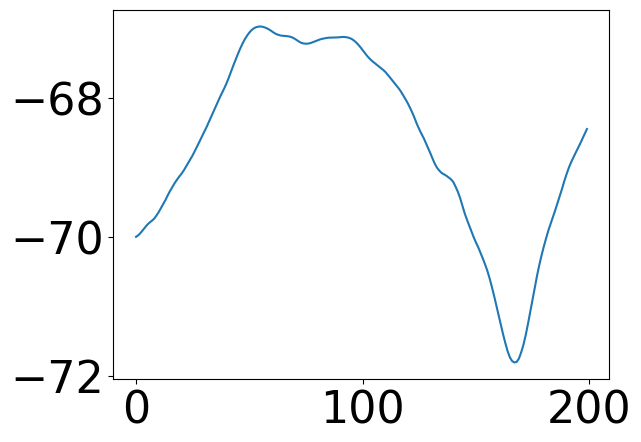

In [19]:
plt.plot(out[0].detach().cpu().numpy().T)